# Querying, Plotting and Storing! 

In [ ]:
import psycopg2
import os
import pandas as pd
import numpy as np

from matplotlib.font_manager import FontProperties
import matplotlib.ticker as tkr
import matplotlib.pyplot as plt
import seaborn

from openpyxl import Workbook
from openpyxl import load_workbook

%matplotlib inline

con=psycopg2.connect(dbname='ibotta', host=os.environ['REDSHIFT_ENDPOINT'], 
port='5439', user=os.environ['REDSHIFT_USER'], password=os.environ['REDSHIFT_PASS'])

### Demographic Queries

Create a workbook that we will later add sheets to

In [3]:
wb = Workbook()
wb.save('query_tables/demographics.xlsx')

Function will for a given demographic, query, plot, create a csv, and create a workbook with the data

In [47]:
def demographic_query(demographic):
    query = '''
    SELECT {demo}, Count(1) as n, 
    COUNT(1) / (SUM(COUNT(1)) OVER ())::float as pct_total 
    FROM customers as a 
    INNER JOIN ibotta_scratch.mcl_10_12_panel_8_9_16 as b 
    ON a.id = b.customer_id 
    GROUP BY {demo} 
    ORDER BY n DESC;
    '''.format(demo=demographic)
    
    df = pd.read_sql_query(query, con)
    
    y_format = tkr.FuncFormatter(lambda x, p: format(int(x), ','))
    
    # Plotting begins
    df_plot = df.copy()
    df_plot.index = df_plot[demographic]
    df_plot.sort_index(inplace=True, ascending=True)

    df_plot[demographic] = df_plot[demographic].replace('',np.nan)
    df_plot = df_plot.dropna()
        
    ax = df_plot.n.plot(kind = 'bar')
    
    ax.yaxis.set_major_formatter(y_format)
    ax.set_ylabel('Number of Panelists')
    ax.set_title('Ibotta Panel '+demographic)
    
    plt.show()
    plt.savefig('figures/panel_'+demographic+'.pdf', bbox_inches='tight')
    
    
    df.to_csv('query_tables/'+demographic+'.csv', index=False)

    book = load_workbook('query_tables/demographics.xlsx')
    writer = pd.ExcelWriter('query_tables/demographics.xlsx', engine='openpyxl') 
    writer.book = book
    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)
    df.to_excel(writer, sheet_name=demographic, index=False)
    writer.save()
    
    return df 

In [48]:
df_i_gender.

,gender,n,pct_total
0,F,316739,0.869479
1,M,37075,0.101774
2,,10472,0.028747


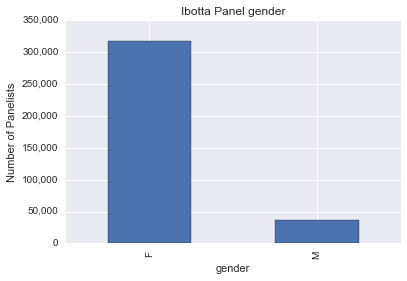

In [49]:
df_i_gender = demographic_query('gender')



And of course we should just loop

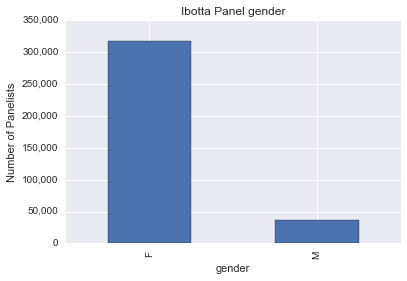

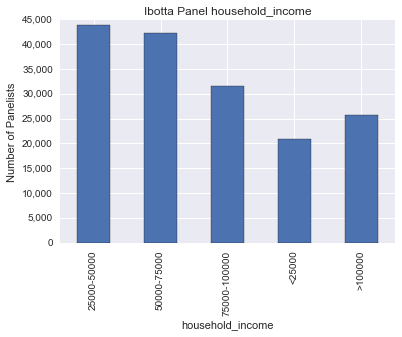

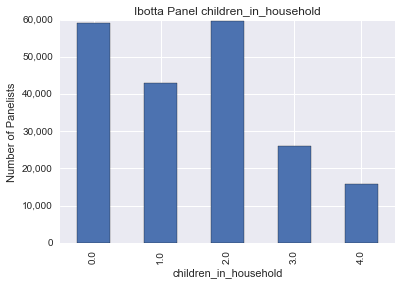

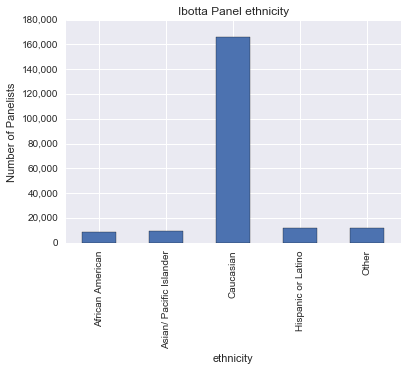

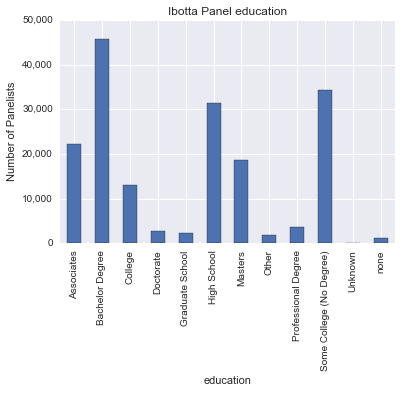

In [50]:
demographics = ['gender', 'household_income', 'children_in_household', 'ethnicity', 'education']

dfs = []
for demographic in demographics:
    dfs.append(demographic_query(demographic))

# Analysis of geography compared to census

In [20]:
query = '''
SELECT a.state, Count(1) as n, 
COUNT(1) / (SUM(COUNT(1)) OVER ())::float as pct_total 
FROM customers as a 
INNER JOIN ibotta_scratch.mcl_10_12_panel_8_9_16 as b 
ON a.id = b.customer_id 
GROUP BY state 
ORDER BY n DESC;
'''

In [21]:
df_i_st = pd.read_sql_query(query, con)

In [22]:
query2 = 'SELECT * FROM state_names'

In [23]:
df_c_st = pd.read_csv('/Users/MikeLewis/Documents/census_project/data/SCPRC-EST2014-18+POP-RES.csv')

In [24]:
df_state_names = pd.read_sql_query(query2, con)

In [25]:
df_c_st = df_c_st.merge(df_state_names[['name', 'abbrev', 'census_region_name']] \
                            ,how='left', left_on='NAME', right_on='name')

In [26]:
df_c_st[df_c_st['abbrev'].isnull()]

,SUMLEV,REGION,DIVISION,STATE,NAME,POPESTIMATE2014,POPEST18PLUS2014,PCNT_POPEST18PLUS,name,abbrev,census_region_name
0,10,0,0,0,United States,318857056,245273438,76.9,NaN,NaN,NaN


''

/Users/MikeLewis/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Helvetica Neuve'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


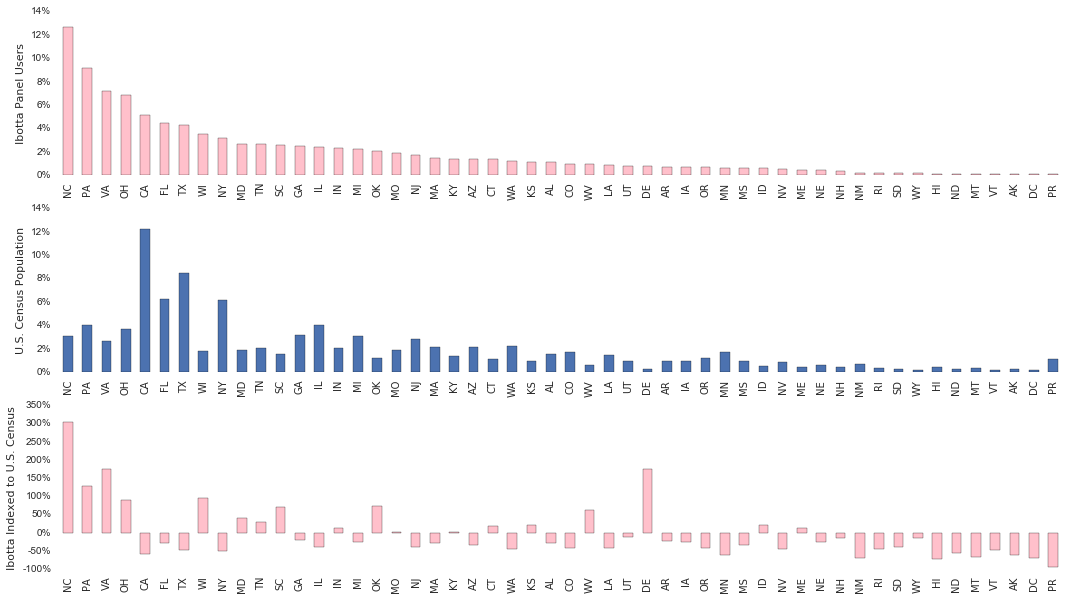

In [31]:
font = {'fontname':'Helvetica Neuve'}

df_st_plt = df_i_st.merge(df_c_st, how='inner', left_on='state', right_on='abbrev')

y_format1 = tkr.FuncFormatter(lambda x, p: '%1.0f'%(100*x)+'%')
y_format2 = tkr.FuncFormatter(lambda x, p: format(int(x)/1000000, ','))

fig, axes = plt.subplots(3)

ax = df_st_plt.pct_total.plot(kind='bar', figsize=(18,10), ax=axes[0], color='pink', grid=False)
ax.set_xticklabels(df_st_plt.state, **font)
ax.yaxis.set_major_formatter(y_format1)
# ax.text(df_st_plt.pct_total)
ax.set_ylabel('Ibotta Panel Users', **font)
ax.set_axis_bgcolor('w')

df_st_plt['pop_pct'] = df_st_plt.eval('POPESTIMATE2014 / 318857056')

ax2 = df_st_plt.pop_pct.plot(kind='bar', figsize=(18,10), ax=axes[1])
ax2.set_xticklabels(df_st_plt.state, **font)
ax2.yaxis.set_major_formatter(y_format1)
ax2.set_ylabel('U.S. Census Population', **font)
ax2.set_axis_bgcolor('w')

df_st_plt['i_index'] = df_st_plt.eval('(pct_total/pop_pct)-1')
ax2 = df_st_plt.i_index.plot(kind='bar', figsize=(18,10), ax=axes[2], color='pink')
ax2.set_xticklabels(df_st_plt.state, **font)
ax2.yaxis.set_major_formatter(y_format1)
ax2.set_ylabel('Ibotta Indexed to U.S. Census', **font)
ax2.set_axis_bgcolor('w')
;




/Users/MikeLewis/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


''

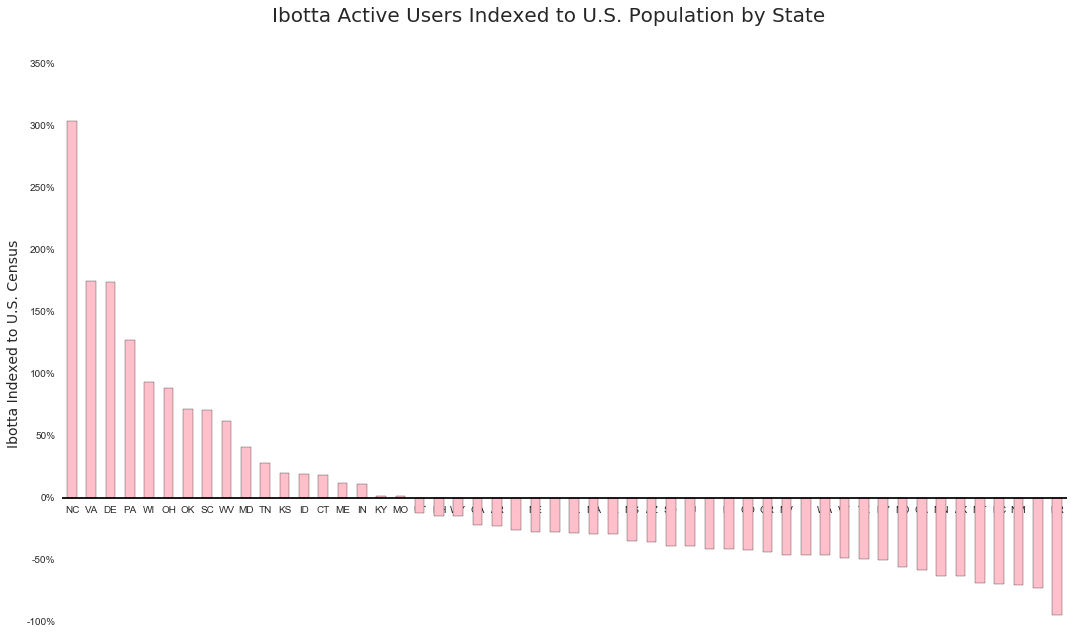

In [30]:
font = {'fontname':'Helvetica Neue Light'}

df_st_plt.sort('i_index', ascending=False, inplace=True)
df_st_plt['pop_pct'] = df_st_plt.eval('POPESTIMATE2014 / 318857056')

y_format1 = tkr.FuncFormatter(lambda x, p: '%1.0f'%(100*x)+'%')
y_format2 = tkr.FuncFormatter(lambda x, p: format(int(x)/1000000, ','))

fig = plt.figure()

df_st_plt['i_index'] = df_st_plt.eval('(pct_total/pop_pct)-1')
ax = df_st_plt.i_index.plot(kind='bar', figsize=(18,10), color='pink')
fig.suptitle('Ibotta Active Users Indexed to U.S. Population by State', fontsize=20, **font)
ax.set_xticklabels(df_st_plt.state, **font)
ax.yaxis.set_major_formatter(y_format1)
ax.set_ylabel('Ibotta Indexed to U.S. Census', fontsize=14, **font)
ax.set_axis_bgcolor('w')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_position('zero')
plt.axhline(0, color='black')
ax.get_xaxis().set_visible(True)
;


In [14]:
# df_st_plt.head()
df_st_plt[['state', 'NAME', 'i_index']].to_csv('data/state_index_data.csv ', header=False, index=False)

In [16]:
df_st_plt[['state', 'NAME', 'n', 'pct_total', 'POPESTIMATE2014', 'pop_pct', 'i_index']].to_csv('data/state_data.csv', header=False)